 # Prediction of users for scooter-rental using regression models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('scooter_rental_data.csv')

# Exploratory Data Analysis

In [4]:
df.head()

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,-2,10


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17958 entries, 0 to 17957
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    17958 non-null  object 
 1   hr                      17958 non-null  int64  
 2   weather                 17958 non-null  object 
 3   temperature             17958 non-null  float64
 4   feels-like-temperature  17958 non-null  float64
 5   relative-humidity       17958 non-null  float64
 6   windspeed               17958 non-null  float64
 7   psi                     17958 non-null  int64  
 8   guest-users             17958 non-null  int64  
 9   registered-users        17958 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 1.4+ MB


In [6]:
# Changing date to datetime format
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

# Creating additional time related features to make date useful in our analysis
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month_name()
df['dayofweek'] = df['date'].dt.day_name()

In [7]:
df.weather.value_counts()

weather
clear              11186
cloudy              4492
light snow/rain     1429
lear                 323
CLEAR                288
loudy                111
CLOUDY                95
LIGHT SNOW/RAIN       31
heavy snow/rain        3
Name: count, dtype: int64

In [8]:
# Rectify all the typing errors in weather column
df.weather = df.weather.str.lower()


def weather(x):
    if x == 'lear':
        return 'clear'
    elif x == 'loudy':
        return 'cloudy'
    elif x == 'heavy snow/rain':
        return 'light snow/rain'
    else: return x



In [9]:
df.weather = df.weather.apply(weather)
df.weather.value_counts()

weather
clear              11797
cloudy              4698
light snow/rain     1463
Name: count, dtype: int64

In [10]:
# Preparing our target column
df['total_users'] = df['guest-users'] + df['registered-users']
df['total_users']

0         185
1         471
2         391
3         148
4           8
         ... 
17953    2049
17954    3299
17955      10
17956     713
17957    4174
Name: total_users, Length: 17958, dtype: int64

In [11]:
# Deleting the columns after transformation

df = df.drop(columns=['date', 'guest-users', 'registered-users'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17958 entries, 0 to 17957
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hr                      17958 non-null  int64  
 1   weather                 17958 non-null  object 
 2   temperature             17958 non-null  float64
 3   feels-like-temperature  17958 non-null  float64
 4   relative-humidity       17958 non-null  float64
 5   windspeed               17958 non-null  float64
 6   psi                     17958 non-null  int64  
 7   year                    17958 non-null  int32  
 8   month                   17958 non-null  object 
 9   dayofweek               17958 non-null  object 
 10  total_users             17958 non-null  int64  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 1.4+ MB


<Axes: xlabel='total_users', ylabel='Count'>

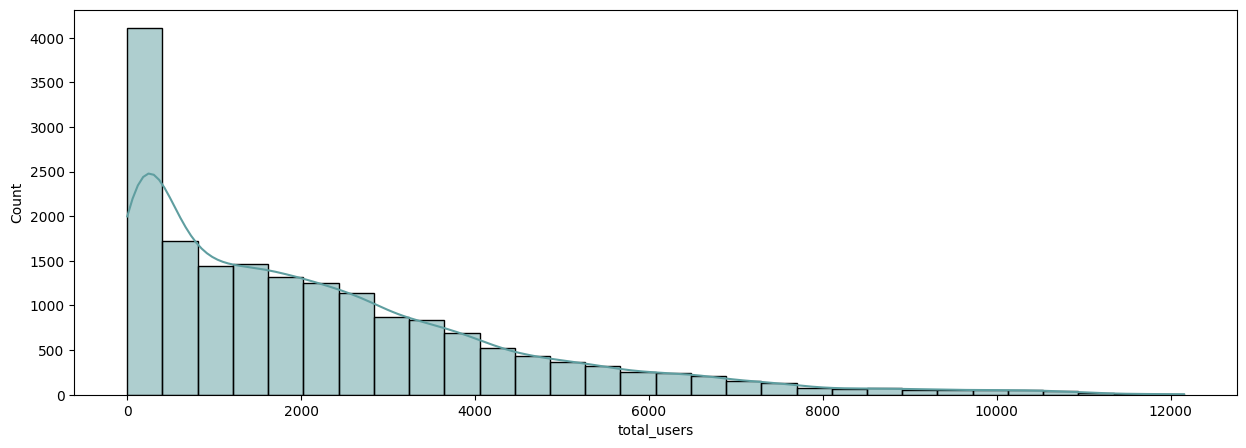

In [13]:
plt.figure(figsize=(15,5))
sns.histplot(df.total_users, bins=30, kde=True, color='cadetblue')

- We can see how positively skewed our target column is.  
- We will lose most of the data while triming outliers.
- We can take the log of total_users and see what happens.

In [14]:
df['log_total_users'] = np.log(df.total_users)

<Axes: xlabel='log_total_users', ylabel='Count'>

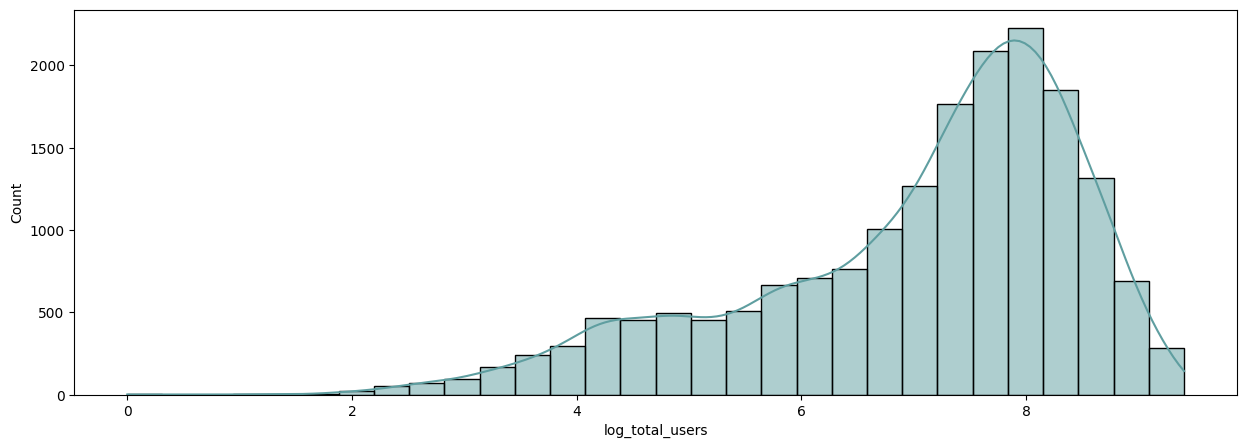

In [15]:
plt.figure(figsize=(15,5))
sns.histplot(df.log_total_users, bins=30, kde=True, color='cadetblue')

- After taking a logarithmic transformation, the distribution is still negatively skewed but looks much more normally distributed. We will be using the log-transformed variable as the new target as it has a more normal distribution which typically leads to a better model fit.  

In [16]:
df = df.drop('total_users', axis=1)

In [17]:
df.describe()

,hr,temperature,feels-like-temperature,relative-humidity,windspeed,psi,year,log_total_users
count,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000
mean,11.533578,88.457512,117.332008,62.758993,12.733155,24.557300,2011.502450,7.014162
std,6.915319,16.285017,20.416251,19.266532,8.213750,14.451091,0.500008,1.483661
min,0.000000,48.100000,60.800000,0.000000,0.000000,0.000000,2011.000000,0.000000
25%,6.000000,75.200000,100.400000,48.000000,7.000000,12.000000,2011.000000,6.180017
50%,12.000000,88.700000,118.400000,63.000000,13.000000,24.000000,2012.000000,7.437795
75%,18.000000,102.200000,134.600000,78.000000,17.000000,37.000000,2012.000000,8.104326
max,23.000000,131.000000,179.600000,100.000000,57.000000,49.000000,2012.000000,9.405414


#### Comparing Total Users Across Different Years

<Figure size 1500x800 with 0 Axes>

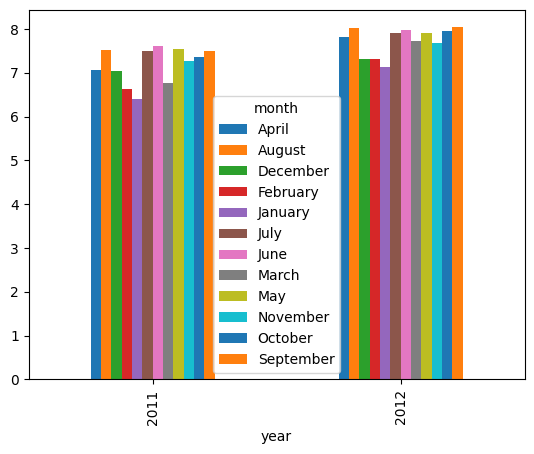

In [18]:
plt.figure(figsize=(15,8))
(df.pivot_table(index='year', columns='month', values='log_total_users', aggfunc='median')).plot(kind='bar')
plt.show()

- From the figure, we can see that the company has been successful in achieving growth in user acquisitions with the median and total number of users across all months have increased year on year.

<Axes: xlabel='month'>

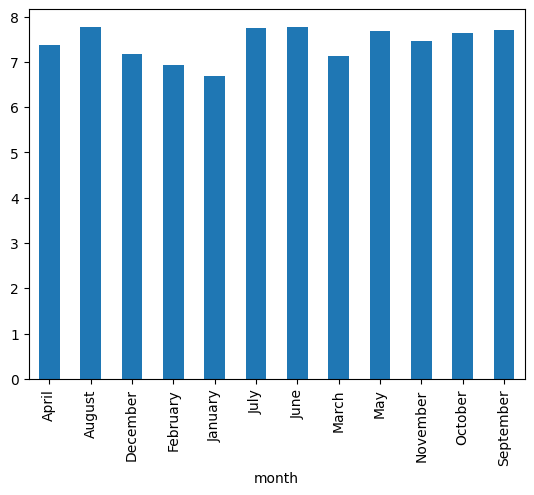

In [19]:
df.groupby('month')['log_total_users'].median().plot(kind='bar')

- As the months get hotter, the number of users increases.

<Axes: xlabel='dayofweek'>

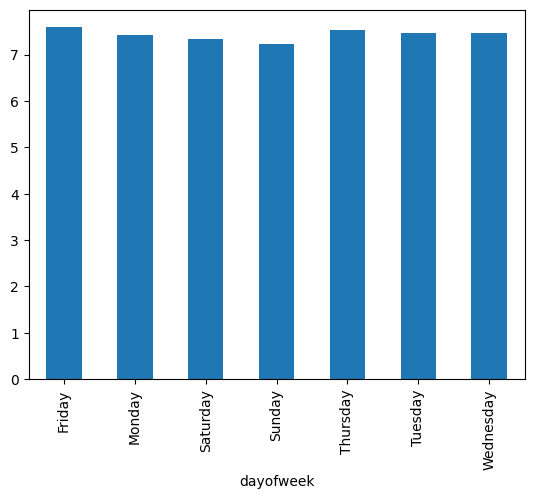

In [20]:
df.groupby('dayofweek')['log_total_users'].median().plot(kind='bar')

- Weekends have less number of users than the weekdays.
- Interesting to see that the number of users increase as days go from Monday to Friday.

<Axes: xlabel='weather'>

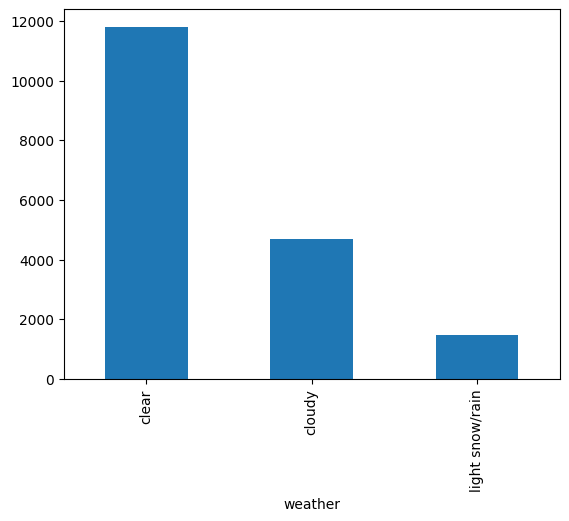

In [21]:
df.groupby('weather')['log_total_users'].count().plot(kind='bar')

- We can see there is a huge difference in total number of users when the weather gets better.

<Axes: xlabel='hr'>

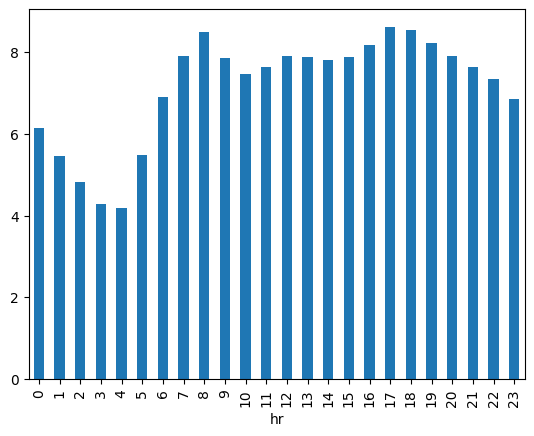

In [22]:
df.groupby('hr')['log_total_users'].median().plot(kind='bar')

- Only a few users rent scooters before 7. The peak hours start from 8 and again after 18 hr the number of users start declining.

<Axes: xlabel='temperature', ylabel='log_total_users'>

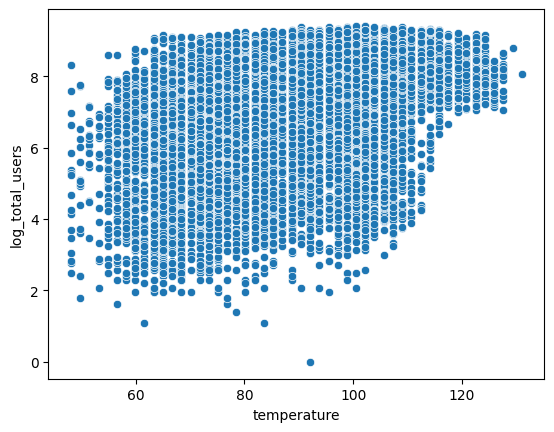

In [23]:
sns.scatterplot(x='temperature', y='log_total_users', data=df)

<Axes: xlabel='feels-like-temperature', ylabel='log_total_users'>

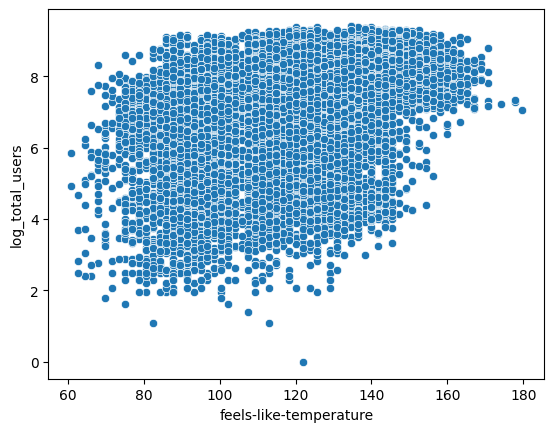

In [24]:
sns.scatterplot(x='feels-like-temperature', y='log_total_users', data=df)

- The results of temperature and feels-like-temperature are similiar, only feels-like-temperature has a larger scale.
- There are less number of very hot days but number of users in these days are always high.

<Axes: xlabel='relative-humidity', ylabel='log_total_users'>

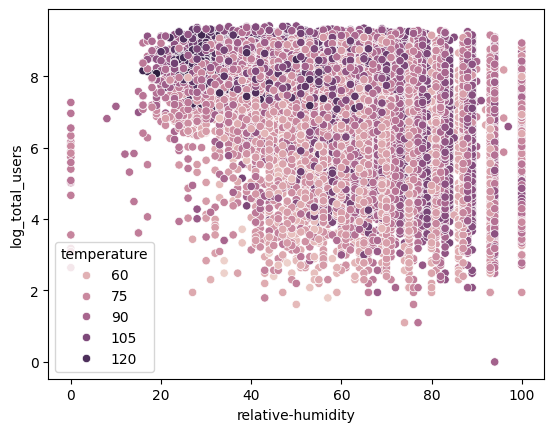

In [25]:
sns.scatterplot(x='relative-humidity', y='log_total_users', hue='temperature', data=df)

- Less number of days where relative humidity is less, but the number of users in these days are more.
- It has a negative correlation with total users.

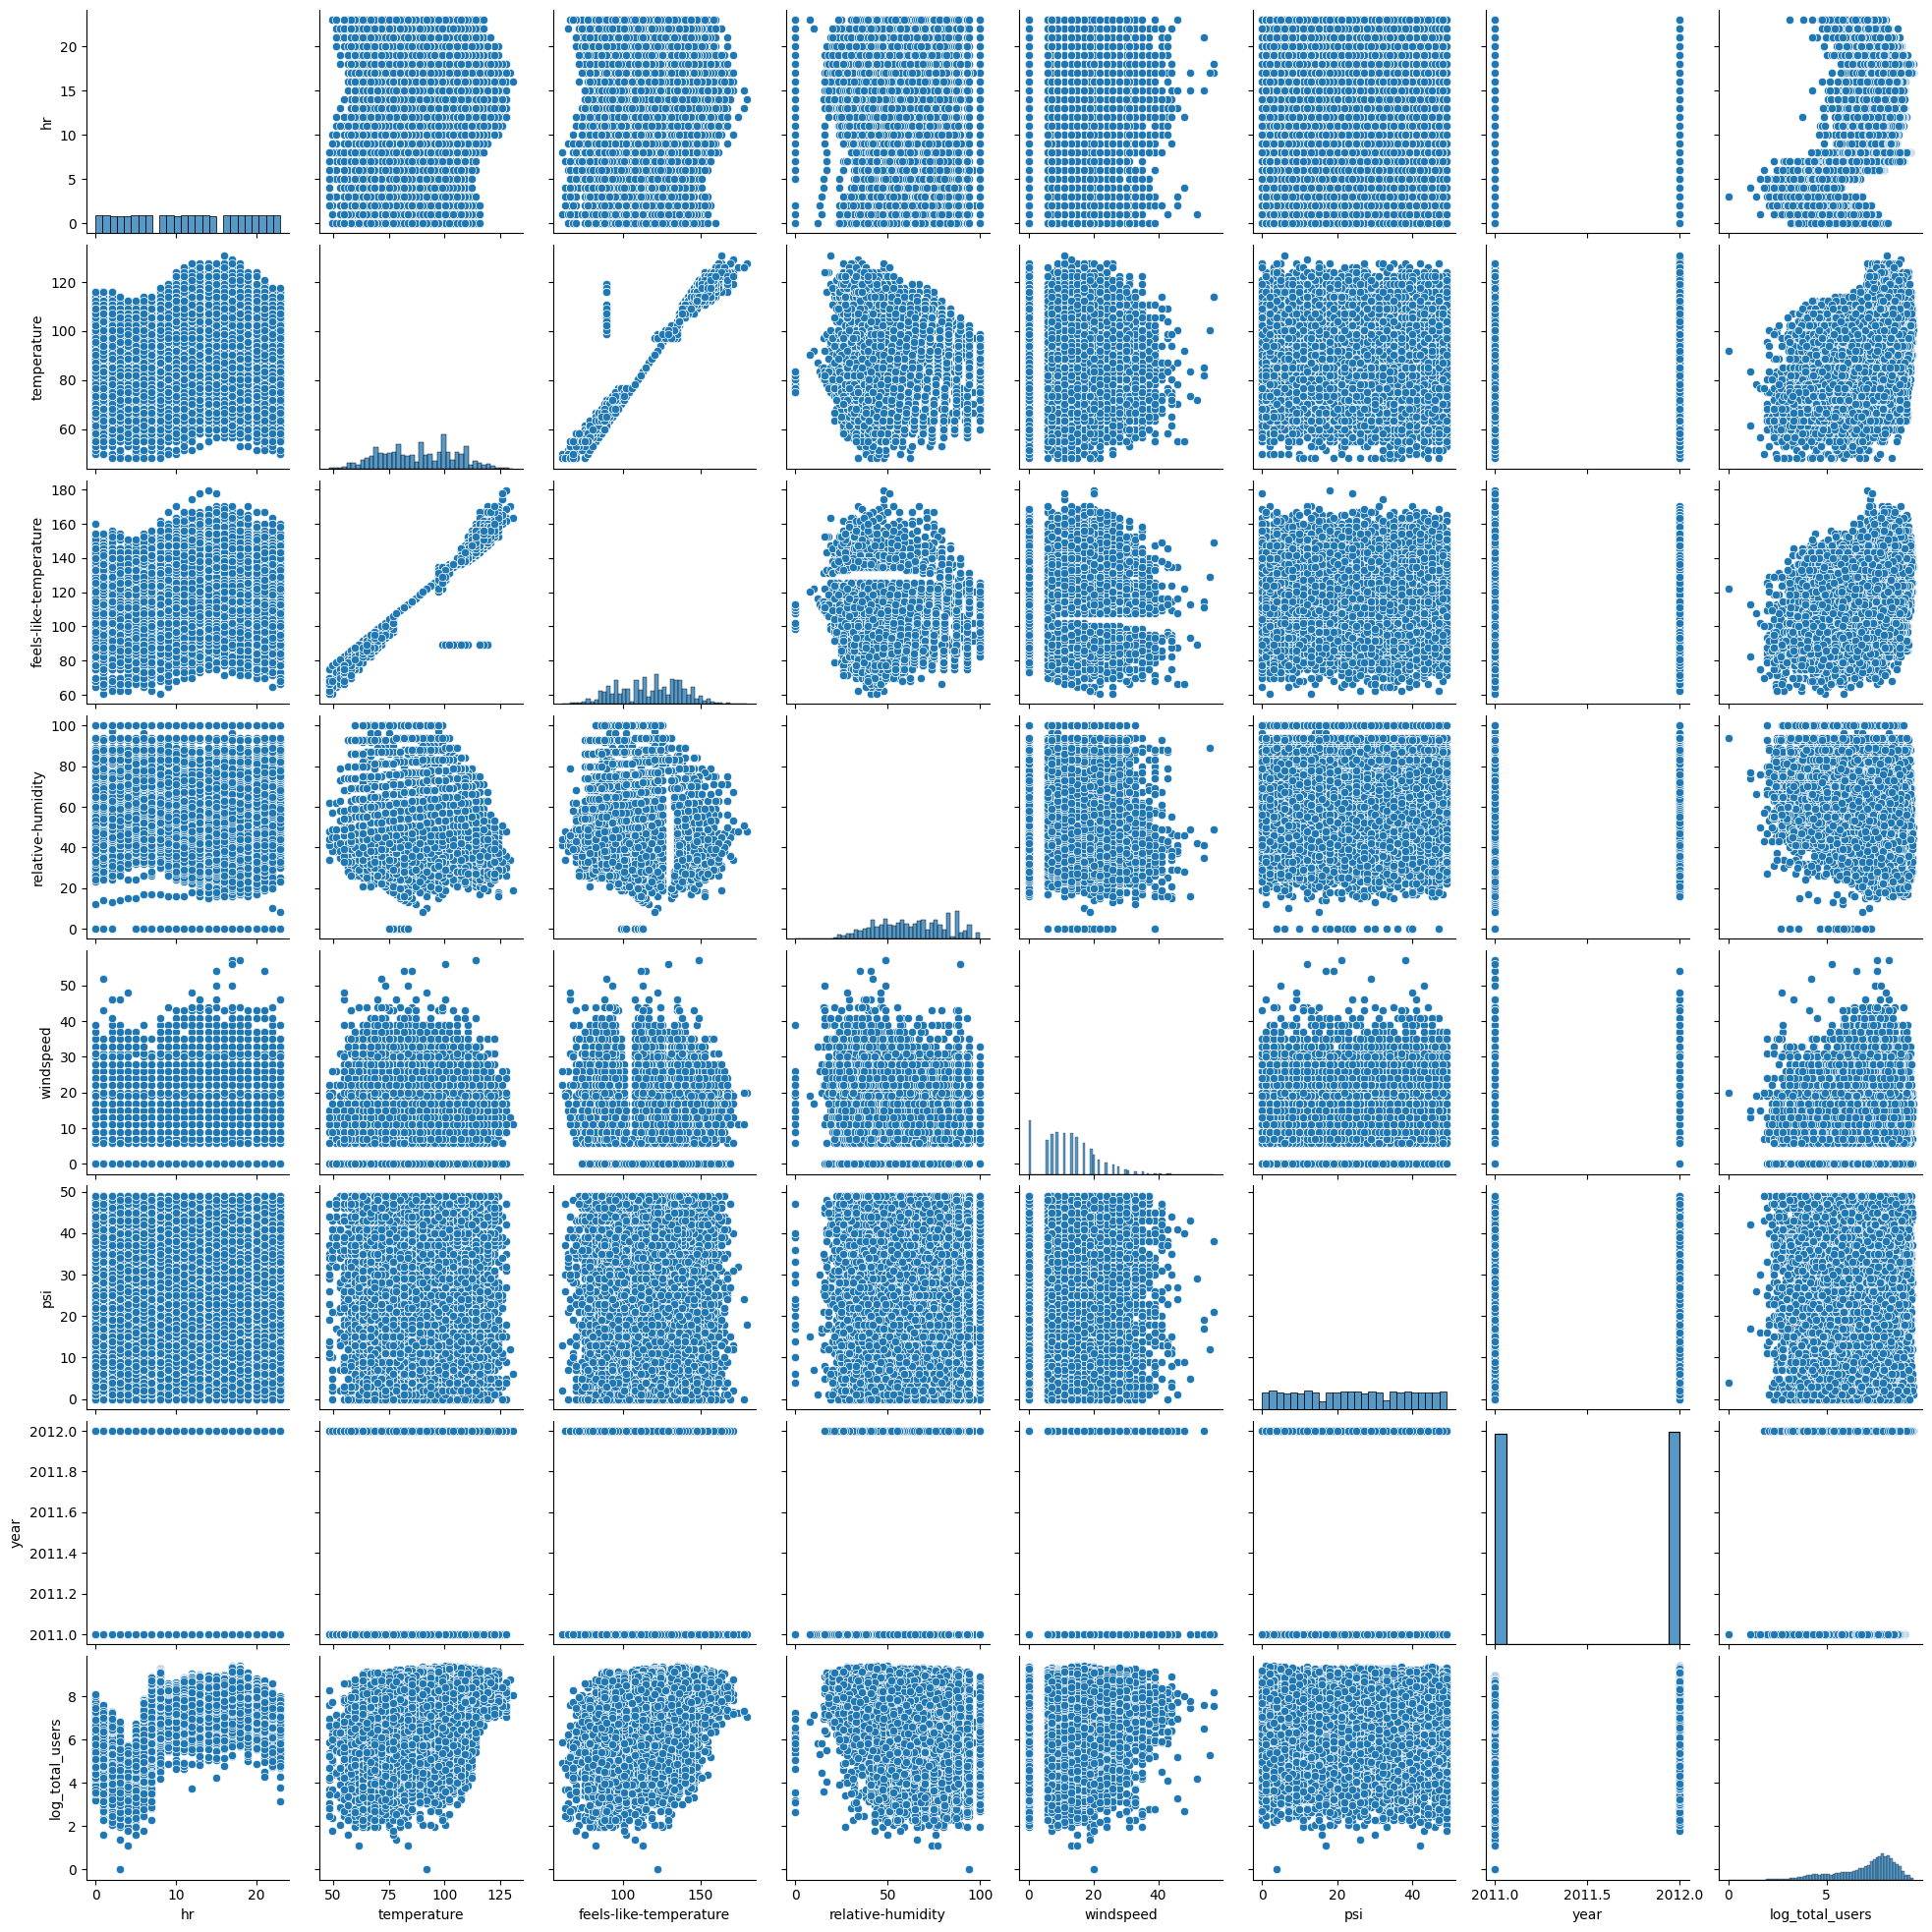

In [26]:
sns.pairplot(df)

- Psi seems to have no meaningful relationships.
- Windspeed seems to have a positive correlation with total users.

Lets check the correlation:

In [27]:
df_num = df.select_dtypes('number')

<Axes: >

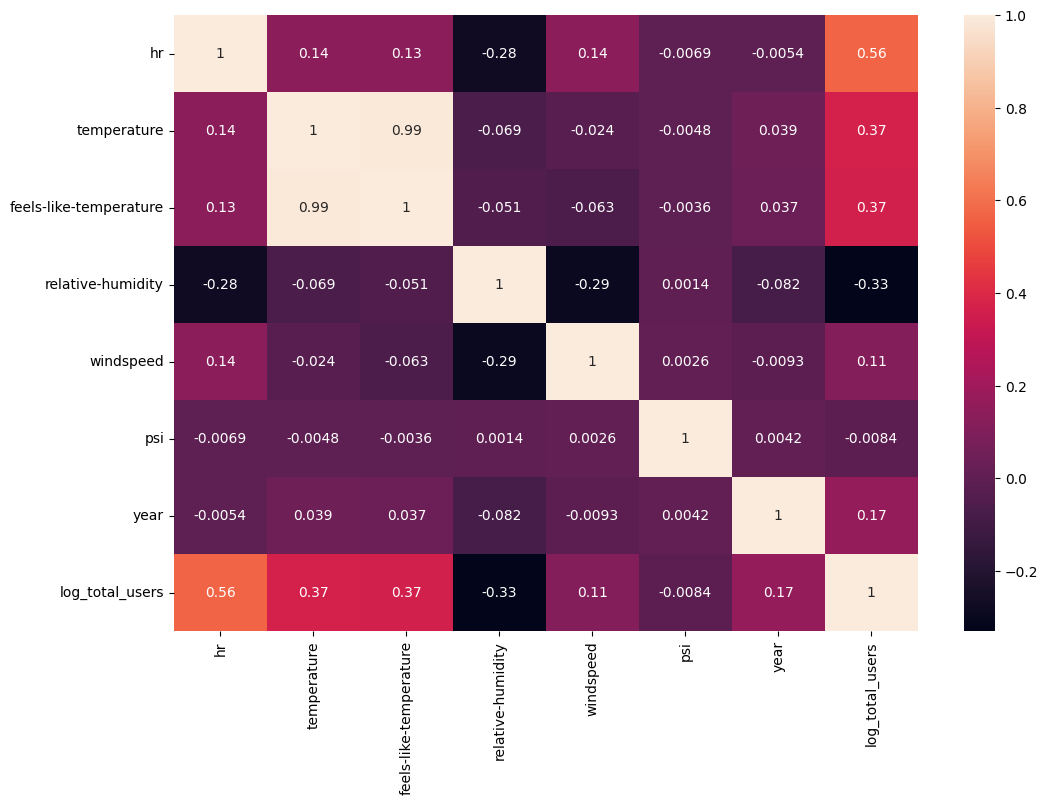

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(df_num.corr(), annot=True)

#### We will drop psi because of its low correlation with total users and feels-like-temperature as it is highly correlated with temperature.

In [29]:
df = df.drop(columns=['psi','feels-like-temperature'])

In [30]:
df.head()

,hr,weather,temperature,relative-humidity,windspeed,year,month,dayofweek,log_total_users
0,0,clear,66.7,81.0,0.0,2011,January,Saturday,5.220356
1,1,clear,65.0,80.0,0.0,2011,January,Saturday,6.154858
2,2,clear,65.0,80.0,0.0,2011,January,Saturday,5.968708
3,3,clear,66.7,75.0,0.0,2011,January,Saturday,4.997212
4,4,clear,66.7,75.0,0.0,2011,January,Saturday,2.079442


# Data Preprocessing

#### Checking for null values

In [31]:
df.isna().sum()

hr                   0
weather              0
temperature          0
relative-humidity    0
windspeed            0
year                 0
month                0
dayofweek            0
log_total_users      0
dtype: int64

In [32]:
df = df.replace(' ', np.nan)
df.isna().sum()

hr                   0
weather              0
temperature          0
relative-humidity    0
windspeed            0
year                 0
month                0
dayofweek            0
log_total_users      0
dtype: int64

In [33]:
df = df.replace('?', np.nan)
df.isna().sum()

hr                   0
weather              0
temperature          0
relative-humidity    0
windspeed            0
year                 0
month                0
dayofweek            0
log_total_users      0
dtype: int64

#### Checking outliers

<Axes: >

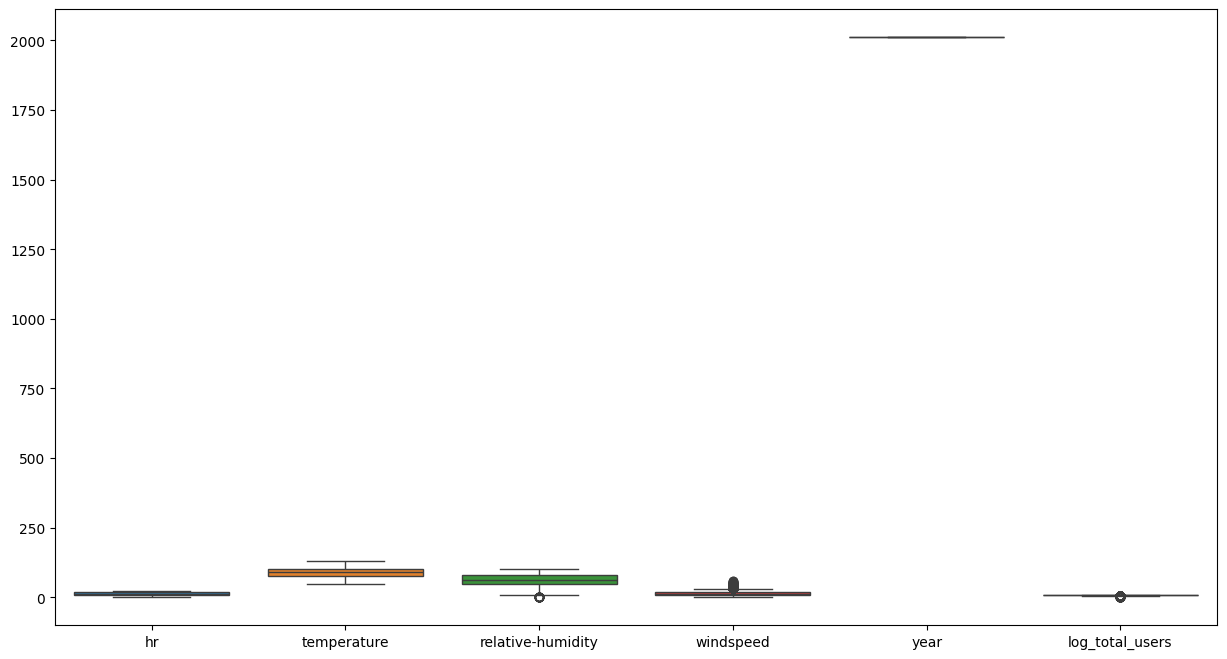

In [34]:
plt.figure(figsize=(15,8))
sns.boxplot(df)

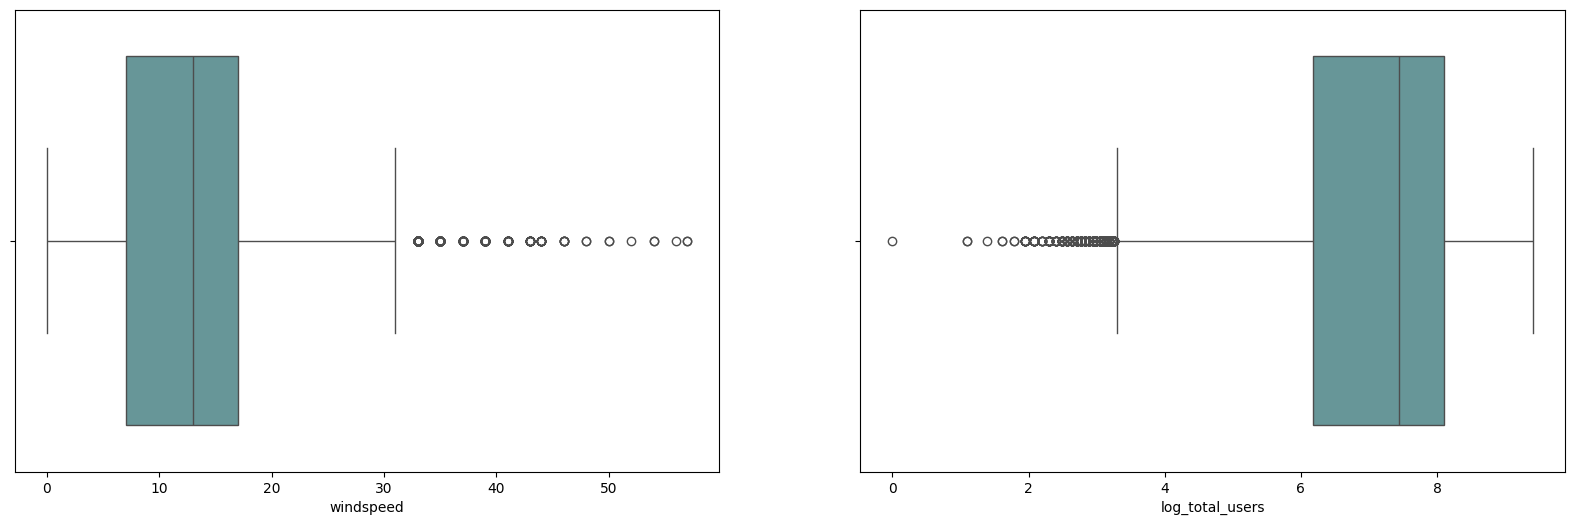

In [35]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.boxplot(x=df['windspeed'], color='cadetblue')

plt.subplot(1,2,2)
sns.boxplot(x=df['log_total_users'], color='cadetblue')

plt.show()

In [36]:
df_num = df.select_dtypes('number')

In [37]:
Q1 = df_num.quantile(.25)
Q3 = df_num.quantile(.75)
IQR = Q3 - Q1
lower_b = Q1 - 1.5*IQR
upper_b = Q3 + 1.5*IQR

In [38]:
df = df[~((df_num < lower_b) | (df_num > upper_b)).any(axis=1)]

In [39]:
df.shape

(17274, 9)

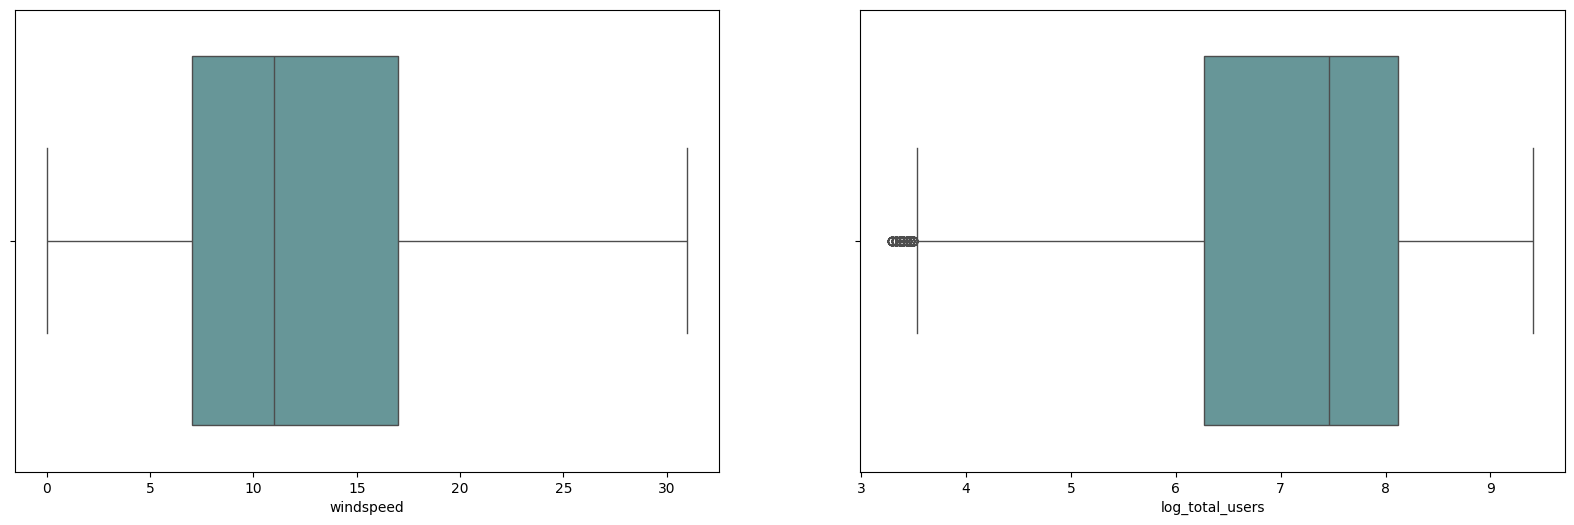

In [40]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.boxplot(x=df['windspeed'], color='cadetblue')

plt.subplot(1,2,2)
sns.boxplot(x=df['log_total_users'], color='cadetblue')

plt.show()

No positive outliers remaining so we will now trim for lower bound only as to not trim relevant data.

In [65]:
df_num = df.select_dtypes('number')

In [66]:
Q1 = df_num.quantile(.25)
Q3 = df_num.quantile(.75)
IQR = Q3 - Q1
lower_b = Q1 - 1.5*IQR
upper_b = Q3 + 1.5*IQR

In [67]:
df = df[~(df_num < lower_b).any(axis=1)]

In [68]:
df.shape

(17016, 9)

<Axes: xlabel='log_total_users'>

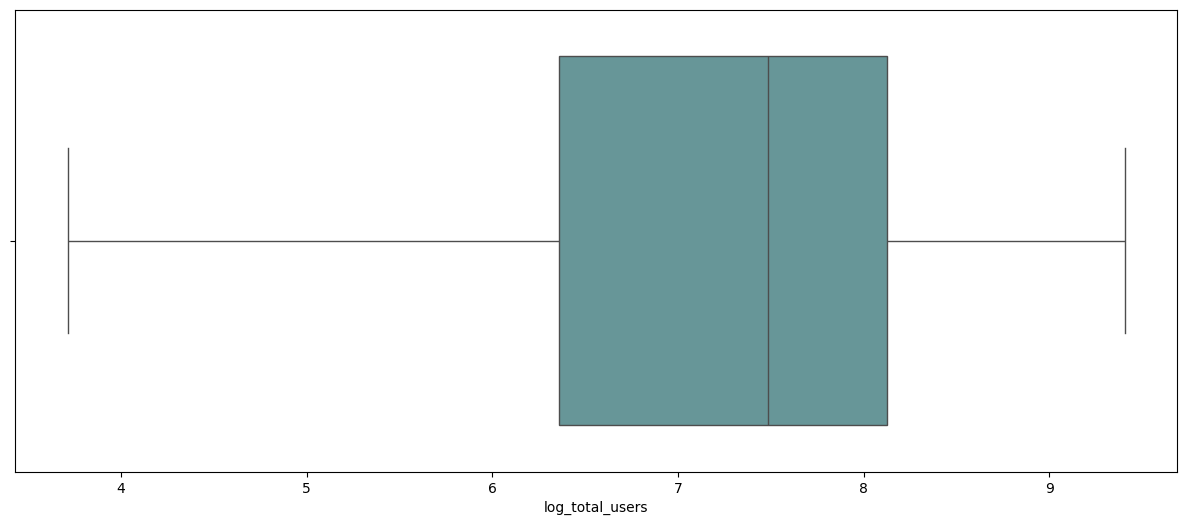

In [69]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['log_total_users'], color='cadetblue')

<Axes: >

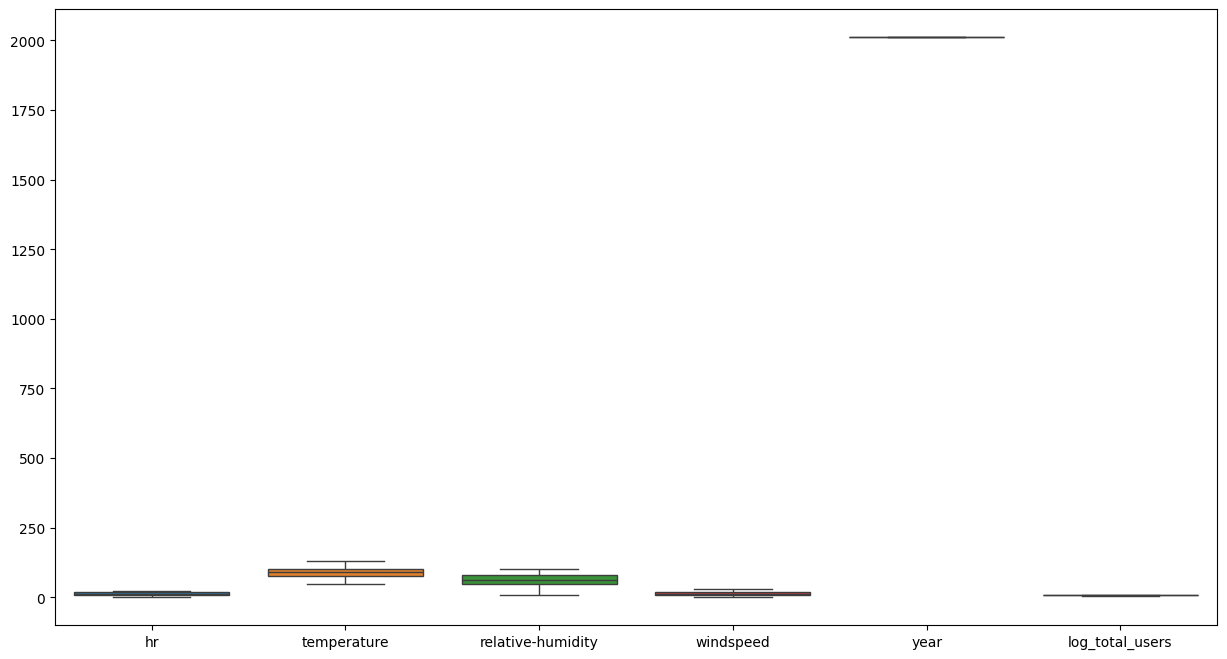

In [70]:
plt.figure(figsize=(15,8))
sns.boxplot(df)

Removed all outliers.

In [71]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [72]:
train.to_csv('train_set.csv', index=False)
test.to_csv('test_set.csv', index=False)

In [73]:
X_train = train.drop("log_total_users", axis=1)
y_train = train["log_total_users"]

In [74]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

In [76]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [77]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [78]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [79]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [80]:
pre = Pipeline(steps=[('preprocessor', preprocessor)])

In [88]:
pre.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['hr', 'temperature', 'relative-humidity', 'windspeed'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['weather', 'month', 'dayofweek'], dtype='object'))]))])

In [89]:
import pickle

with open('preprocess.pkl', 'wb') as f:
    pickle.dump(pre, f)